# Packages

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

In [3]:
import os
os.getcwd()

%cd /g/data/p66/ars599/work_bj_index/plot_bj/

/g/data/p66/ars599/work_bj_index/plot_bj


Thanks for those Notebooks from Wilma and reminding us of the earlier one form Andy on the different scaling maps of GM and redi coefficients once he played with the numbers it looks a bit like those agm maps  I produced out of the model run, but his plots are nicer.

I am surprised how much difference the higher values of made to the mixed layer depths particularly in the Greenland Labrador Seas and in the Weddell sea but she still gets the multidecadal signal that was of concern even with the convection turned down so much.

The convection being reduced is more realistic though we do want some source of multidecadal variability form those high latitude regions.  I will have a look at the ice in cq880 runs when I have time.  I am bit busy with a few other things at the moment, I would expect a lot less polynya problems than before in cj877 in the Southern Ocean.

Definitely worth trying these parameters in our model runs, we may need to scale some of out other GM numbers in the neutral physics as well to match as you can see from the purple line in Andys plot it does jump up the values in the ACC a  lot and we achieved this by different methods last time, so will impact the Drake Passage ACC flow in SV so a few things to watch,  but iif it generates more decadal variability which can undrlay our North Pacific and trigger activity into the tropics then it will be no bad thing.
Default values in OM2 0.25 (and used in cj877) were

agm_closure_scaling = 0.07
agm_closure_grid_scaling_power = 2.0

cq880 changed to

agm_closure_scaling = 0.21
agm_closure_grid_scaling_power = 4.0


Default values in OM2 0.25 (and used in cj877) were

agm_closure_scaling = 0.07
agm_closure_grid_scaling_power = 2.0

cq880 changed to

agm_closure_scaling = 0.21
agm_closure_grid_scaling_power = 4.0


In [4]:
# read sw netcdf file

idir_org = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/"
idir = "/g/data/p66/ars599/CMIP6/APP_output/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/"

# pdControl without/with WAMBAT
# mrd599 1 ocean piControl
ds21 = xr.open_dataset(idir_org+'piControl/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc')
# mrd599 1 ocean pdControl
ds22 = xr.open_dataset(idir+'piControl/r1i1p3f1/Amon/ts/gn/v20230517/ts_Amon_ACCESS-CM2_piControl_r1i1p3f1_gn_050001-059912.nc')
# mrd599 1/4 ocean
ds31 = xr.open_dataset(idir+'piControl/r1i2p1f2/Amon/ts/gn/v20230523/ts_Amon_ACCESS-CM2_piControl_r1i2p1f2_gn_030001-039912.nc')
# dhb599 1/4 ocean + bgc
ds32 = xr.open_dataset(idir+'piControl/r1i2p1f3/Amon/ts/gn/v20230523/ts_Amon_ACCESS-CM2_piControl_r1i2p1f3_gn_030001-039912.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full nump

In [30]:
# calcualte N3
# 5°S–5°N, 210°–270°
def calculate_2d_anom(var):
    var_clim = var.groupby("time.month").mean(dim="time")
    var_anom = var.groupby("time.month") - var_clim
    return var_anom

# -- Detorending
import numpy as np
import xarray as xr

def detrend_3d(da, deg=1):
    """
    Detrend 3D data (time, lat, lon) along all dimensions.
    
    Parameters:
        da (xarray.DataArray): The input data array.
        deg (int): The degree of polynomial for detrending. Default is 1 (linear).

    Returns:
        detrended (xarray.DataArray): Detrended data array.
    Usage:
        # Example usage:
        # Assuming `sst_data` is your 3D SST data array (time, lat, lon)
        detrended_sst = detrend_3d(sst_data)

    """
    # Stack lat and lon dimensions into a single dimension
    stacked_da = da.stack(points=[da.lat, da.lon])

    # Detrend along the time dimension
    def detrend_dim(da, dim, deg=1):
        p = da.polyfit(dim=dim, deg=deg)
        fit = xr.polyval(da[dim], p.polyfit_coefficients)
        return da - fit

    detrended_stacked = stacked_da.groupby('time').apply(detrend_dim, dim='time', deg=deg)

    # Unstack lat and lon dimensions back
    detrended_da = detrended_stacked.unstack('points')
    return detrended_da

def detrend_dim(da, dim, deg=1):
    """
    Detrend along a single dimension using polynomial fitting.
    
    Parameters:
        da (xarray.DataArray): The input data array.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of polynomial for detrending. Default is 1 (linear).

    Returns:
        detrended (xarray.DataArray): Detrended data array.
    """
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    detrended = da - fit
    return detrended

#def calculate_n3_anom(da):
#    sst = da['ts']
#    sst = detrend_dim(calculate_2d_anom(sst), 'time', 0)
#    sst = sst.sel(time=slice(300, 399))
#    sst_ts = sst.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(dim=('lat', 'lon'))
#    return sst_ts

def calculate_n3_anom(da, ystart, ylast):
    ystart_str = str(ystart).zfill(4)
    ylast_str = str(ylast).zfill(4)
    
    sst = da['ts']
    sst = detrend_dim(calculate_2d_anom(sst), 'time', 0)
    sst = sst.sel(time=slice(ystart_str, ylast_str))
    sst_ts = sst.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(dim=('lat', 'lon'))
    return sst_ts


In [6]:
# Example usage:
# Assuming you have a dataset named 'ds'
# 0950-1449
n3_anom21 = calculate_n3_anom(ds21,950,1049)
# 0500-0599
n3_anom22 = calculate_n3_anom(ds22,500,599)
# 0300-0399
n3_anom31 = calculate_n3_anom(ds31,300,399)
n3_anom32 = calculate_n3_anom(ds32,300,399)



In [7]:
n3_anom21.name = 'ts'
n3_anom22.name = 'ts'
n3_anom31.name = 'ts'
n3_anom32.name = 'ts'
n3_anom32

<xarray.DataArray 'ts' (time: 1200)>
array([-0.54119385, -0.44858275,  0.13116562, ...,  0.16201861,
        0.17104573,  0.29469999])
Coordinates:
  * time     (time) object 0300-01-16 12:00:00 ... 0399-12-16 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [8]:
n3_anom21.to_netcdf('n3_anom21.nc')
n3_anom22.to_netcdf('n3_anom22.nc')
n3_anom31.to_netcdf('n3_anom31.nc')
n3_anom32.to_netcdf('n3_anom32.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


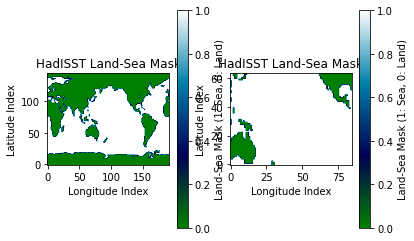

In [9]:
'''
generate land sea mask from hadisst
'''

idir = "/g/data/p66/ars599/obs/month/"
hadisst_ds  = xr.open_dataset(idir+'HadISST_sst.1870-2020.N96.clim.nc')

# Extract the 'sst' variable from the dataset
sst = hadisst_ds['sst'][0]

# Set the missing value threshold for identifying land and sea
missing_value = np.nan

# Create the land-sea mask where 1 represents sea, 0 represents land, and missing values are considered as land
land_sea_mask = np.where(np.isnan(sst), 0, 1)

sst_pac = sst.sel(lon=slice(120, 280), lat=slice(-40, 40))
lsm_pac = np.where(np.isnan(sst_pac), 0, 1)

# Plot the land-sea mask
plt.subplot(121)
plt.imshow(land_sea_mask, cmap='ocean', origin='lower')
plt.colorbar(label='Land-Sea Mask (1: Sea, 0: Land)')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.title('HadISST Land-Sea Mask')

plt.subplot(122)
plt.imshow(lsm_pac, cmap='ocean', origin='lower')
plt.colorbar(label='Land-Sea Mask (1: Sea, 0: Land)')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.title('HadISST Land-Sea Mask')

plt.show()

## ========= skip below ==============

## ========= Skip above =============

# EOF

In [35]:
'''

# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
ranm = anm.rolling(time=7, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)

https://climate.usu.edu/people/yoshi/pyclm101/monthly.html
'''
idir = "/g/data/p66/ars599/obs/month/"
hadisst_ds  = xr.open_dataset(idir+'HadISST_sst.1870-2020.N96.dtanom.nc')

# Extract the 'sst' variable from the dataset
sst = hadisst_ds['sst']
# so far 3d detrend is not working !!!
#sst = detrend_3d(sst)
sst

<xarray.DataArray 'sst' (time: 1840, lat: 144, lon: 192)>
[50872320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T12:00:00 ... 2023-04-16T12:00:00
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean
    lonFlip:        longitude coordinate variable has been reordered via lonFlip

In [36]:
# 40°S–40°N, 120°–280°
def calculate_pac_anom(ds):
    n3_raw = ds.sel(lon=slice(120, 280), lat=slice(-40, 40))
    n3_clim = n3_raw.groupby("time.month").mean(dim="time")
    n3_anom = n3_raw.groupby("time.month") - n3_clim
    return n3_anom

n3_anomobs = calculate_pac_anom(hadisst_ds)
n3_anomobs = n3_anomobs.sel(time=slice('1980','2022'))
n3_anom21 = calculate_pac_anom(ds21)
n3_anom21 = n3_anom21.sel(time=slice('1350','1449'))
n3_anom22 = calculate_pac_anom(ds22)
n3_anom31 = calculate_pac_anom(ds31)
n3_anom32 = calculate_pac_anom(ds32)


In [37]:
'''
https://pypi.org/project/sacpy/
'''
import sacpy as scp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sacpy.Map as smap
from scipy.linalg import svd

def plot_eof2(ssta,ttl,fName):
    '''
    # Example usage:
    # Assuming you have a variable 'ssta'
    ssta = n3_anom1.ts
    plot_eof(ssta)
    '''
    eof = scp.EOF(np.array(ssta))
    eof.solve()
    pc = eof.get_pc(npt=2)
    pt = eof.get_pt(npt=2)

    lon, lat = np.array(ssta.lon), np.array(ssta.lat)

    # Check and ensure positive pt at 90W 0N
    lon_index = np.abs(lon - 240).argmin()  # Find the index for 120W
    lat_index = np.abs(lat - 0).argmin()    # Find the index for 0N

    if pt[0, lat_index, lon_index] < 0:
        pt[0] *= -1
        pc[0] *= -1
    if pt[1, lat_index, lon_index] < 0:
        pt[1] *= -1
        pc[1] *= -1

    fig = plt.figure(figsize=[12, 7])
    ax = fig.add_subplot(221)
    m1 = ax.contourf(lon, lat, pt[0, :, :], cmap='RdBu_r', levels=np.linspace(-0.75, 0.75, 15), extend="both")
    ax.contour(m1, colors="black")
    ax.set_title(ttl[0])
    ax2 = fig.add_subplot(222)
#    ax2.plot(ssta.time, pc[0])
    ax2.plot(pc[0])
    ax2.grid()
    ax2.set_title(ttl[1])
    ax3 = fig.add_subplot(223) #, projection=ccrs.PlateCarree(central_longitude=180))
    m2 = ax3.contourf(lon, lat, pt[1, :, :], cmap='RdBu_r', levels=np.linspace(-0.75, 0.75, 15), extend="both")
    ax3.contour(m2, colors="black")
    ax3.set_title(ttl[2])
    ax4 = fig.add_subplot(224)
#    ax4.plot(ssta.time, pc[1])
    ax4.plot(pc[1])
    ax4.grid()
    ax4.set_title(ttl[3])

    cb_ax = fig.add_axes([0.1, 0.06, 0.4, 0.02])
    fig.colorbar(m1, cax=cb_ax, orientation="horizontal")
    
    plt.savefig(fName+".png",dpi=300)
    plt.show()

    # Return the PCs as a tuple
    return pc

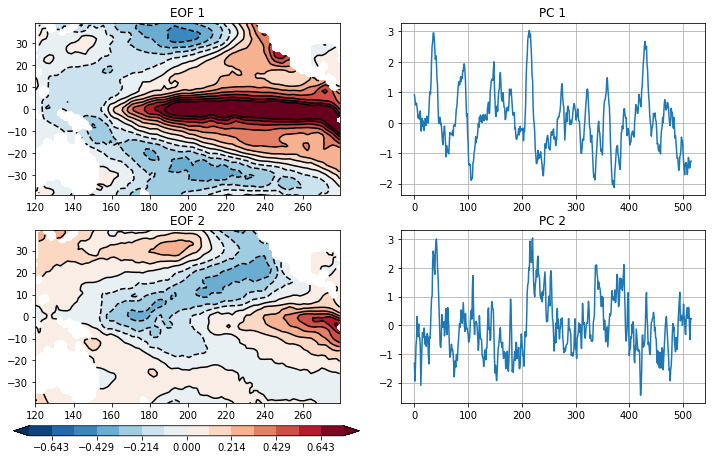

In [38]:
ssta_tmp = n3_anomobs.sst
# Ensure the land-sea mask has the same shape as the SSTA data along the time dimension
#lsm_pac_expanded = np.tile(lsm_pac[np.newaxis, :, :], (ssta_tmp.shape[0], 1, 1))
# Apply the land-sea mask to the SSTA data
#ssta = np.where(lsm_pac_expanded == 1, ssta_tmp, np.nan)
ssta = ssta_tmp # xr.DataArray(ssta, coords=ssta_tmp.coords, attrs=ssta_tmp.attrs)
ttl = ('EOF 1','PC 1','EOF 2','PC 2')
fName = "n3_anomobs_eof_ana"
pcs_obs = plot_eof2(ssta,ttl,fName)

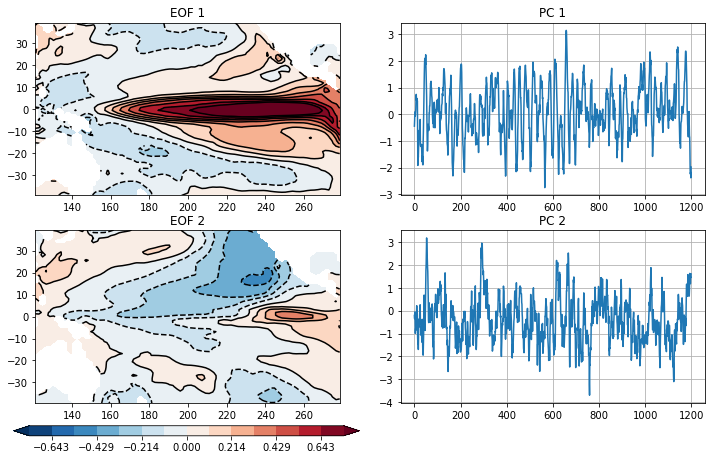

In [74]:
ssta_tmp = n3_anom21.ts
# Ensure the land-sea mask has the same shape as the SSTA data along the time dimension
lsm_pac_expanded = np.tile(lsm_pac[np.newaxis, :, :], (ssta_tmp.shape[0], 1, 1))
# Apply the land-sea mask to the SSTA data
ssta = np.where(lsm_pac_expanded == 1, ssta_tmp, np.nan)
ssta = xr.DataArray(ssta, coords=ssta_tmp.coords, attrs=ssta_tmp.attrs)
ttl = ('EOF 1','PC 1','EOF 2','PC 2')
fName = "n3_anom21_eof_ana"
pcs_21 = plot_eof2(ssta,ttl,fName)

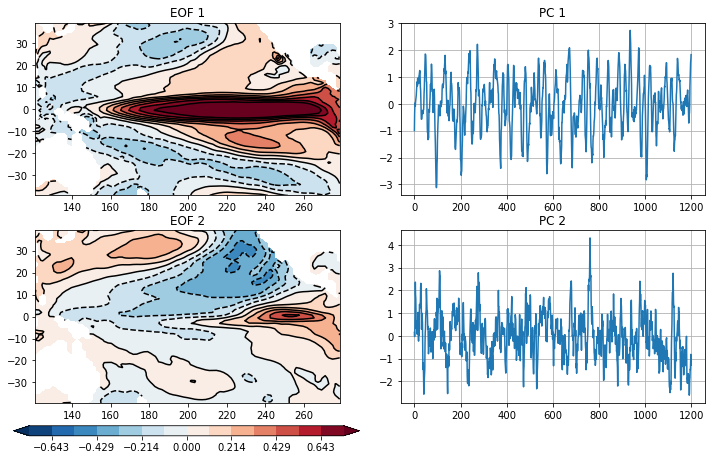

In [75]:
ssta_tmp = n3_anom22.ts
# Ensure the land-sea mask has the same shape as the SSTA data along the time dimension
lsm_pac_expanded = np.tile(lsm_pac[np.newaxis, :, :], (ssta_tmp.shape[0], 1, 1))
# Apply the land-sea mask to the SSTA data
ssta = np.where(lsm_pac_expanded == 1, ssta_tmp, np.nan)
ssta = xr.DataArray(ssta, coords=ssta_tmp.coords, attrs=ssta_tmp.attrs)
ttl = ('EOF 1','PC 1','EOF 2','PC 2')
fName = "n3_anom22_eof_ana"
pcs_22 = plot_eof2(ssta,ttl,fName)

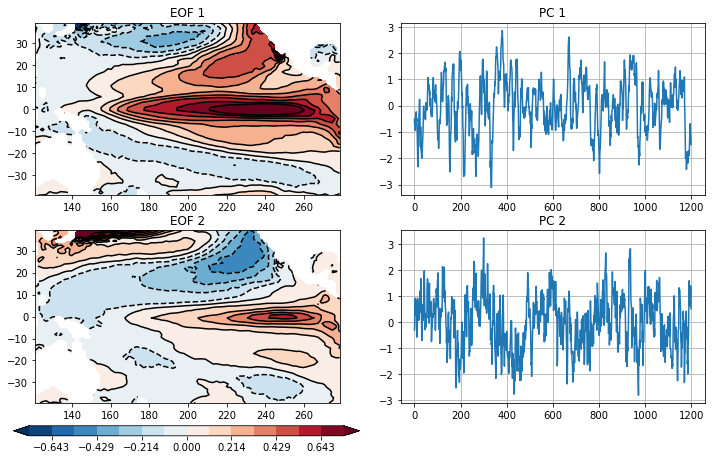

In [76]:
ssta_tmp = n3_anom31.ts
# Ensure the land-sea mask has the same shape as the SSTA data along the time dimension
lsm_pac_expanded = np.tile(lsm_pac[np.newaxis, :, :], (ssta_tmp.shape[0], 1, 1))
# Apply the land-sea mask to the SSTA data
ssta = np.where(lsm_pac_expanded == 1, ssta_tmp, np.nan)
ssta = xr.DataArray(ssta, coords=ssta_tmp.coords, attrs=ssta_tmp.attrs)
ttl = ('EOF 1','PC 1','EOF 2','PC 2')
fName = "n3_anom31_eof_ana"
pcs_31 = plot_eof2(ssta,ttl,fName)

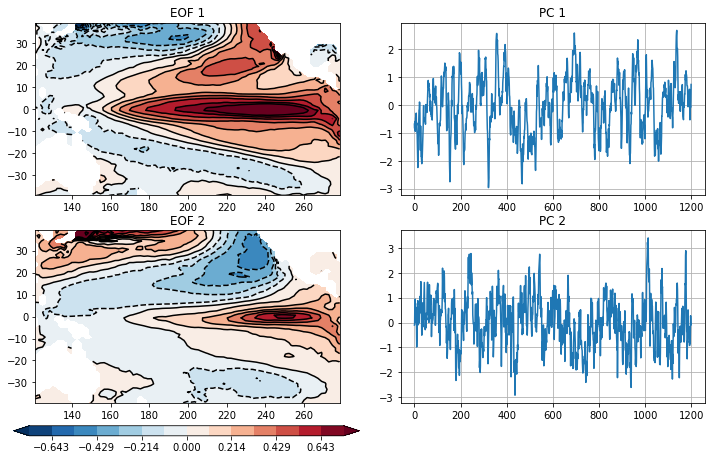

In [77]:
ssta_tmp = n3_anom32.ts
# Ensure the land-sea mask has the same shape as the SSTA data along the time dimension
lsm_pac_expanded = np.tile(lsm_pac[np.newaxis, :, :], (ssta_tmp.shape[0], 1, 1))
# Apply the land-sea mask to the SSTA data
ssta = np.where(lsm_pac_expanded == 1, ssta_tmp, np.nan)
ssta = xr.DataArray(ssta, coords=ssta_tmp.coords, attrs=ssta_tmp.attrs)
ttl = ('EOF 1','PC 1','EOF 2','PC 2')
fName = "n3_anom32_eof_ana"
pcs_32 = plot_eof2(ssta,ttl,fName)

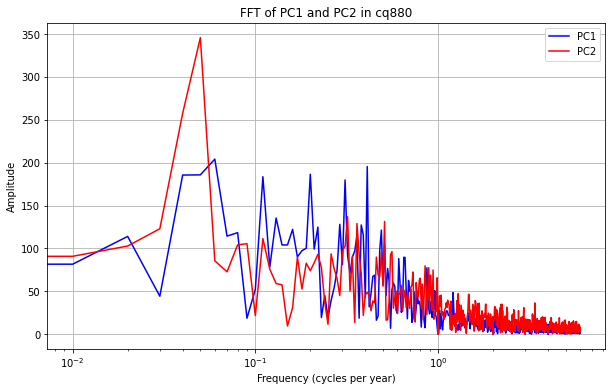

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have obtained PC1 and PC2 as 1-dimensional arrays (time series)
# Replace pc1 and pc2 with your actual PC1 and PC2 data

fName = 'pcs_31'
pc1 = pcs_31[0]
pc2 = pcs_31[1]

# Calculate the sampling rate (time resolution)
sampling_rate = 1  # Replace with the actual time resolution (e.g., if the time step is monthly, sampling_rate = 1)

# Calculate the number of data points
num_points = len(pc1)

# Calculate the frequencies for the FFT
frequencies = np.fft.fftfreq(num_points, d=sampling_rate)

# Calculate the FFT for PC1 and PC2
fft_pc1 = np.fft.fft(pc1)
fft_pc2 = np.fft.fft(pc2)

# Convert frequencies to cycles per year
frequencies_per_year = frequencies * 12

# Plot the FFT of PC1 in blue and PC2 in red with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.plot(frequencies_per_year[:num_points//2], np.abs(fft_pc1[:num_points//2]), color='blue', label='PC1')
plt.plot(frequencies_per_year[:num_points//2], np.abs(fft_pc2[:num_points//2]), color='red', label='PC2')
plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of PC1 and PC2 in cq880')
plt.legend()
plt.grid(True)
plt.savefig(fName+".png", dpi=300)
plt.show()


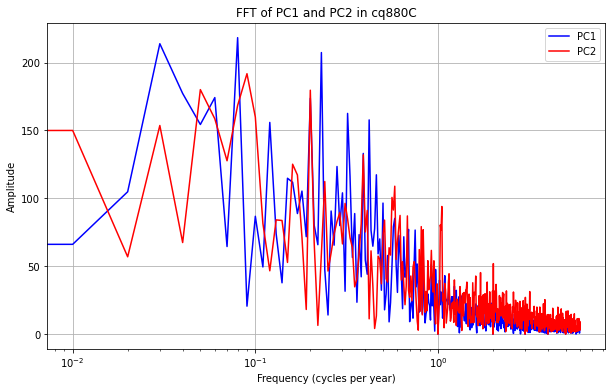

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have obtained PC1 and PC2 as 1-dimensional arrays (time series)
# Replace pc1 and pc2 with your actual PC1 and PC2 data

fName = 'pcs_32'
pc1 = pcs_32[0]
pc2 = pcs_32[1]

# Calculate the sampling rate (time resolution)
sampling_rate = 1  # Replace with the actual time resolution (e.g., if the time step is monthly, sampling_rate = 1)

# Calculate the number of data points
num_points = len(pc1)

# Calculate the frequencies for the FFT
frequencies = np.fft.fftfreq(num_points, d=sampling_rate)

# Calculate the FFT for PC1 and PC2
fft_pc1 = np.fft.fft(pc1)
fft_pc2 = np.fft.fft(pc2)

# Convert frequencies to cycles per year
frequencies_per_year = frequencies * 12

# Plot the FFT of PC1 in blue and PC2 in red with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.plot(frequencies_per_year[:num_points//2], np.abs(fft_pc1[:num_points//2]), color='blue', label='PC1')
plt.plot(frequencies_per_year[:num_points//2], np.abs(fft_pc2[:num_points//2]), color='red', label='PC2')
plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of PC1 and PC2 in cq880C')
plt.legend()
plt.grid(True)
plt.savefig(fName+".png", dpi=300)
plt.show()


# FFT Spectrum from Harun

In [40]:
import powerSpectrum
specx_ci = powerSpectrum.specx_ci
spectrum = powerSpectrum.spectrum

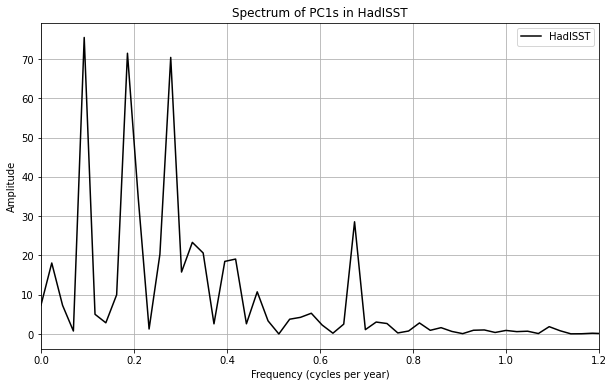

In [42]:
fName = 'pcs_obs_harun'
pc1_obs = pcs_obs[0]
pcs0, pts0 = spectrum(pc1_obs)

# Calculate the number of data points
num_points = len(pcs0)

# Convert frequencies to cycles per year
frequencies_per_year = pcs0 * 12

# Plot the FFT of PC1 in blue and PC2 in red with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts0[:num_points//2]), color='black', label='HadISST')
#plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xlim([0,1.2])
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Spectrum of PC1s in HadISST')
plt.legend()
plt.grid(True)
plt.savefig(fName+".png", dpi=300)
plt.show()

In [81]:
fName = 'pcs_31_harun'
pc1_21 = pcs_21[0]
pc1_22 = pcs_22[0]
pc1_31 = pcs_31[0]
pc1_32 = pcs_32[0]

pcs1, pts1 = spectrum(pc1_21)
pcs2, pts2 = spectrum(pc1_22)
pcs3, pts3 = spectrum(pc1_31)
pcs4, pts4 = spectrum(pc1_32)

print(np.shape(pts1))
print(np.shape(pts2))
print(np.shape(pts3))
print(np.shape(pts4))

(601,)
(601,)
(601,)
(601,)


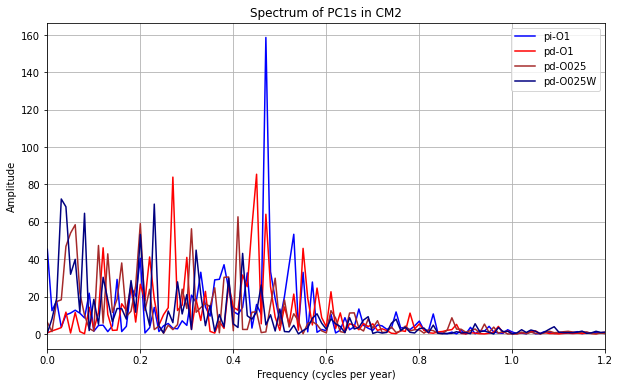

In [88]:
# Calculate the number of data points
num_points = len(pcs1)

# Convert frequencies to cycles per year
frequencies_per_year = pcs1 * 12

# Plot the FFT of PC1 in blue and PC2 in red with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts1[:num_points//2]), color='blue', label='pi-O1')
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts2[:num_points//2]), color='red', label='pd-O1')
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts3[:num_points//2]), color='brown', label='pd-O025')
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts4[:num_points//2]), color='navy', label='pd-O025W')
#plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xlim([0,1.2])
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Spectrum of PC1s in CM2')
plt.legend()
plt.grid(True)
plt.savefig(fName+".png", dpi=300)
plt.show()


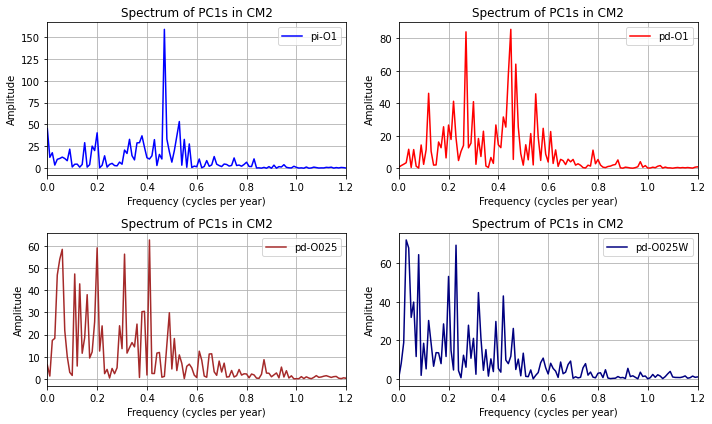

In [89]:
'''
simplise the plot

'''
# Define subplot titles and data
subplot_data = [
    {'color': 'blue', 'label': 'pi-O1', 'data': np.abs(pts1[:num_points//2])},
    {'color': 'red', 'label': 'pd-O1', 'data': np.abs(pts2[:num_points//2])},
    {'color': 'brown', 'label': 'pd-O025', 'data': np.abs(pts3[:num_points//2])},
    {'color': 'navy', 'label': 'pd-O025W', 'data': np.abs(pts4[:num_points//2])}
]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axs = axs.ravel()

# Iterate through subplots and plot data
for i, subplot_info in enumerate(subplot_data):
    axs[i].plot(frequencies_per_year[:num_points//2], subplot_info['data'], color=subplot_info['color'], label=subplot_info['label'])
    axs[i].grid(True)  # Add grid to x-axis limit
    axs[i].set_xlim([0, 1.2])
    axs[i].set_xlabel('Frequency (cycles per year)')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title('Spectrum of PC1s in CM2')
    axs[i].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig(fName+".png", dpi=300)
plt.show()


In [16]:
fName = 'pcs_32_harun'
pc1 = pcs_32[0]
pc2 = pcs_32[1]

pcs1, pts1 = spectrum(pc1)
pcs2, pts2 = spectrum(pc2)

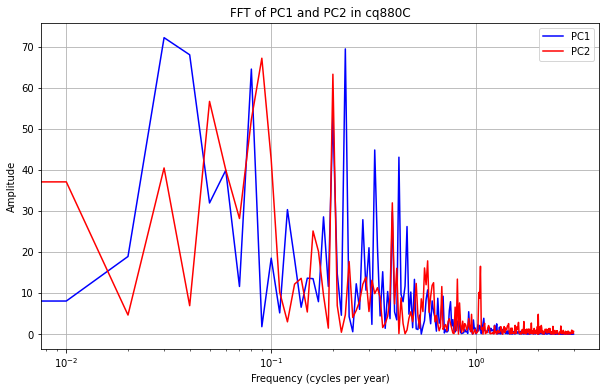

In [17]:
# Calculate the number of data points
num_points = len(pcs1)

# Convert frequencies to cycles per year
frequencies_per_year = pcs1 * 12

# Plot the FFT of PC1 in blue and PC2 in red with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts1[:num_points//2]), color='blue', label='PC1')
plt.plot(frequencies_per_year[:num_points//2], np.abs(pts2[:num_points//2]), color='red', label='PC2')
plt.xscale('log')  # Set logarithmic scale on the x-axis
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of PC1 and PC2 in cq880C')
plt.legend()
plt.grid(True)
plt.savefig(fName+".png", dpi=300)
plt.show()
